In [1]:
# 라이브러리 불러오기
import threading
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from time import sleep

from pose_ArUCo.pose_estimation import run_aruco
from pose_ArUCo.detect_aruco_images import detect_marker
from dobot_api import DobotApiDashboard, DobotApi, DobotApiMove, MyType
from rotate import transform_cam_to_robot

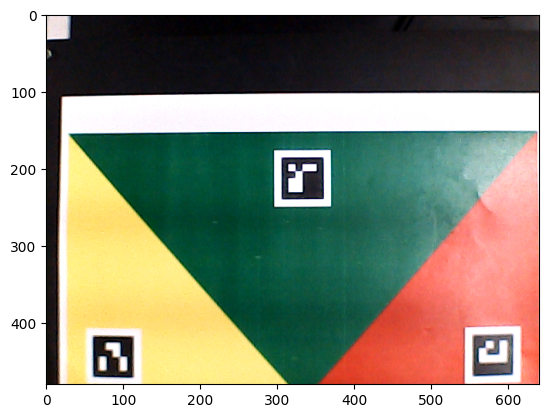

In [2]:
# 웹캠 이미지 받아오기
cap = cv2.VideoCapture(1)
ret, img = cap.read()

# 웹캠 이미지를 RGB로 변환
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 웹캠 이미지 보기
plt.imshow(img_rgb)
plt.show()

Detecting 'DICT_4X4_100' tags....
[Inference] ArUco marker ID: 3
[Inference] ArUco marker ID: 2
[Inference] ArUco marker ID: 1


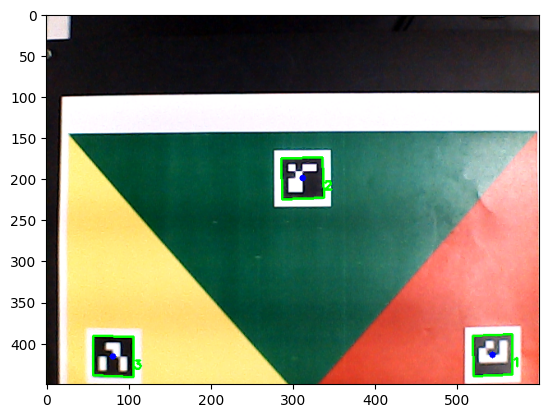

In [3]:
# 마커 검출
detected_markers = detect_marker(image=img_rgb, marker_type="DICT_4X4_100")

# 마커 검출 이미지 보기
plt.imshow(detected_markers)
plt.show()

In [13]:
# 아르코 마커로 카메라 좌표계 기준 6D pose 예측하기
# rvec : 회전 행렬 (roll, pitch, yaw)   // unit : rads
# tvec : 이동 행렬 (x, y, z)            // unit : meter
# corners : 아르코 마커의 각 코너 좌표  // (x, y) 픽셀 위치

rvec, tvec, corners = run_aruco(img, "DICT_4X4_100")

# 간단한 전처리
rvec = np.array(rvec)
tvec = np.array(tvec)
corners = np.array(corners)

# 회전 행렬, 이동 행렬, 마커 코너 좌표 출력
print(f"translation vector : {tvec} meters \n")

ids : [[3]
 [2]
 [1]]
translation vector : [[[[-0.07550851  0.05799422  0.38333062]]]


 [[[ 0.01666926 -0.02854274  0.37938082]]]


 [[[ 0.1077662   0.0562157   0.36890788]]]] meters 



In [21]:
select_order = 0  # 출력된 좌표들 중에서 원하는 좌표를 선택

select_tvec = tvec[select_order][0][0]

array([-0.07550851,  0.05799422,  0.38333062])

In [22]:
# 오차 보정 값 (단위 : cm) ###########################################
edit_x = -49.4
edit_y = -25.9
######################################################################

# 카메라 좌표계 -> 로봇 베이스 좌표계로 변환
point_grip = transform_cam_to_robot(select_tvec)

# 좌표 오차 보정 (수동)
point_grip[0] = round(point_grip[0] + edit_x, 4)
point_grip[1] = round(point_grip[1] + edit_y, 4)

# 고정값
yaw_angle_by_robot = 15    # 회전 값은 임의로 고정
point_grip[2] = -55.5      # z 값은 로봇 베이스 좌표계 기준 물체 높이로 고정 (GetPose 함수로 알아내기)

# yaw 변환 각도 값 추가
point_grip = np.append(point_grip, yaw_angle_by_robot)
print(f"x pose by robot : {point_grip[0]} mm")
print(f"y pose by robot : {point_grip[1]} mm")
print(f"z pose by robot : {point_grip[2]} mm")
print(f"yaw angle by robot : {point_grip[3]} mm")

x pose by robot : 358.6 mm
y pose by robot : -86.9 mm
z pose by robot : -55.5 mm
yaw angle by robot : 15.0 mm


In [ ]:
# 전역 변수 (현재 좌표)
current_actual = None

In [ ]:
# PC-로봇 연결 함수 (TCP/IP 통신)
def connect_robot(ip):
    try:
        dashboard_p = 29999
        move_p = 30003
        feed_p = 30004
        print("연결 설정 중...")

        dashboard = DobotApiDashboard(ip, dashboard_p)
        move = DobotApiMove(ip, move_p)
        feed = DobotApi(ip, feed_p)
        print("연결 성공!!")

        return dashboard, move, feed

    except Exception as e:
        print(":연결 실패ㅜㅜ")
        raise e

In [ ]:
# 로봇 에러 메시지 초기화 함수
def robot_clear(dashboard : DobotApiDashboard):
    dashboard.ClearError()

# 로봇 속도 조절 함수 (speed_value : 1~100)
def robot_speed(dashboard : DobotApiDashboard, speed_value):
    dashboard.SpeedFactor(speed_value)

# 그리퍼 구동 함수 (status 0 -> OFF, 1-> ON)
def gripper_DO(dashboard : DobotApiDashboard, index, status):
    dashboard.ToolDO(index, status)

# 현재 로봇 위치 받아오기 (로봇 베이스 좌표계 기준)
def get_Pose(dashboard : DobotApiDashboard):
    dashboard.GetPose()
    
def get_Error(dashboard : DobotApiDashboard):
    dashboard.GetErrorID()
    
def set_Collision(dashboard : DobotApiDashboard, level):
    dashboard.SetCollisionLevel(level)

In [ ]:
# 로봇 구동 함수 (현재 위치 -> 목표 위치(point_list))
def run_point(move: DobotApiMove, point_list: list):
    move.MovL(point_list[0], point_list[1], point_list[2], point_list[3])

def get_feed(feed: DobotApi):
    global current_actual
    hasRead = 0

    while True:
        data = bytes()
        while hasRead < 1440:
            temp = feed.socket_dobot.recv(1440 - hasRead)
            if len(temp) > 0:
                hasRead += len(temp)
                data += temp
        hasRead = 0
        a = np.frombuffer(data, dtype=MyType)

        if hex((a['test_value'][0])) == '0x123456789abcdef':
            current_actual = a["tool_vector_actual"][0]     # Refresh Properties
        sleep(0.001)

# 로봇이 목표 위치로 도달할 때 까지 기다리는 함수
def wait_arrive(point_list):
    global current_actual
    while True:
        is_arrive = True
        if current_actual is not None:
            for index in range(4):
                if (abs(current_actual[index] - point_list[index]) > 1):
                    is_arrive = False
            if is_arrive:
                return
        sleep(0.001)

In [ ]:
# 입력 파라미터
ip = "192.168.1.6"              # Robot의 IP 주소
gripper_port = 1                # 그리퍼 포트 번호
speed_value = 10                # 로봇 속도 (1~100 사이의 값 입력)

# 로봇이 이동하고자 하는 좌표 (x, y, z, yaw)
point_init = [265, 5, 50, 0] 
point_mid = [245, -7, 55, 0]
point_parse = [255.67, -54.82, -4.85, 0]

In [ ]:
# 로봇 연결
dashboard, move, feed = connect_robot(ip)
dashboard.EnableRobot()
print("이제 로봇을 사용할 수 있습니다!")

# 쓰레드 설정
feed_thread = threading.Thread(target=get_feed, args=(feed,))
feed_thread.setDaemon(True)
feed_thread.start()

In [ ]:
# 로봇 상태 초기화 1 : 로봇 에러 메시지 초기화
robot_clear(dashboard) 

# 로봇 상태 초기화 2 : 로봇 속도 조절
robot_speed(dashboard, speed_value)

# 로봇 현재 위치 받아오기 (x, y, z, yaw) - 로봇 베이스 좌표계 
get_Pose(dashboard)

In [ ]:
# 로봇 구동 1 (point_mid)
run_point(move, point_mid)
sleep(3)

# 로봇 구동 2 (Grip)
run_point(move, point_grip)
sleep(3)

In [ ]:
# 그리퍼 구동
gripper_DO(dashboard, gripper_port, 1)
sleep(0.1)

In [ ]:
# 로봇 구동 1 (point_mid)
run_point(move, point_mid)
sleep(4)

# 로봇 구동 3 (Parse)
run_point(move, point_parse)
sleep(4)

In [ ]:
# 그리퍼 끄기
gripper_DO(dashboard, gripper_port, 0)
sleep(0.1)

In [ ]:
# 로봇 구동 1 (Home)
run_point(move, point_mid)
sleep(4)

In [ ]:
# 로봇 끄기
dashboard.DisableRobot()